In [1]:
import os
import sys
import time
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta

import model_settings
from model_settings import ms, vanilla_pricer, barrier_option_pricer
from plotters import plot_surface
from av_fetchers import underlying, link
vanp = vanilla_pricer()
barp = barrier_option_pricer()

search_symbol = 'SPY'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])


initializing vanilla pricer
Actual/365 (Fixed) day counter
seed: 123

barrier option pricer initialized


,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SPY,SPDR S&P 500 ETF Trust,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,SPY1.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
2,SPY2.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
3,SPY3.LON,Leverage Shares 3x Long US 500 ETP Securities,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
4,SPY4.FRK,SSgA SPDR S&P 400 US Mid Cap,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
5,SPY4.LON,SPDR® S&P 400 US Mid Cap UCITS ETF,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
6,SPY1.DEX,SPDR® S&P 500 Low Volatility UCITS ETF,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
7,SPY2.DEX,SPDR® Dow Jones Global Real Estate UCITS ETF U...,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
8,SPY4.DEX,SSgA SPDR S&P 400 US Mid Cap,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
9,SPY4.PAR,SSgA SPDR S&P 400 US Mid Cap,ETF,Paris,09:00,17:30,UTC+02,EUR,0.6000


In [2]:
symbol = search_symbol
spots = underlying(symbol,ms.av_key)
spots = pd.Series(spots).astype(float)

# example data collection

let us collect a few recent trading days and inspect the data

In [3]:
dates = pd.Series(spots).index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-23
1    2024-10-22
2    2024-10-21
3    2024-10-18
4    2024-10-17
dtype: object


In [4]:
spots

2024-10-23    577.9900
2024-10-22    583.3200
2024-10-21    583.6300
2024-10-18    584.5900
2024-10-17    582.3500
                ...   
1999-11-05    137.8750
1999-11-04    136.5312
1999-11-03    135.5000
1999-11-02    134.5937
1999-11-01    135.5625
Length: 6285, dtype: float64

In [5]:
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    chain_link = link(date,symbol,ms.av_key)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = chain_link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


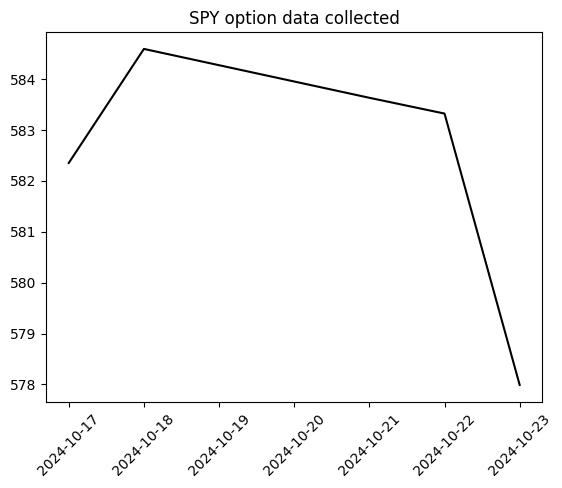

<Figure size 640x480 with 0 Axes>

In [6]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and proceed with an example calibration of our Heston (1993) model

In [7]:
date = dates[0]
raw_data = pd.DataFrame(chain[date])
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Wednesday, October 23rd, 2024


## extracting calibration contracts

In [8]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[df['days_to_maturity']>=7]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
pivoted = df.pivot(index = 'strike',columns='days_to_maturity',values='implied_volatility')


T = np.sort(df['days_to_maturity'].unique())
T = T[T<400]
T = T[np.linspace(0, len(T) - 1, num=5, dtype=int)]

K = np.sort(df['strike'].unique())
K1 = np.sort(pivoted.dropna(how='any',axis=0).index).tolist()
K2 = K[np.linspace(0, len(K) - 1, num=5-len(K1), dtype=int)].tolist()
K = np.sort(np.unique(np.array(K1+K2)))

contracts = pivoted.loc[K,T].unstack().dropna().reset_index().copy()
contracts.columns.values[-1] = 'volatility'

## calibrating a Heston (1993) model

In [9]:
s = spots[date]
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(r),ql.Actual365Fixed()))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,float(g),ql.Actual365Fixed()))
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for i,row in contracts.iterrows():
    t = row['days_to_maturity']
    k = row['strike']
    p = ql.Period(int(t),ql.Days)
    volatility = row['volatility']
    helper = ql.HestonModelHelper(
        p, ql.UnitedStates(ql.UnitedStates.NYSE), float(s), k, 
        ql.QuoteHandle(ql.SimpleQuote(volatility)), 
        flat_ts, 
        dividend_ts
        )
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = {'kappa':kappa,'theta':theta,'rho':rho,'eta':eta,'v0':v0}
heston_parameters = pd.Series(heston_parameters)
print(heston_parameters)

kappa    26.133363
theta     0.035026
rho      -0.867460
eta       4.667297
v0        0.036377
dtype: float64


# repricing calibration contracts

In [10]:
contracts[heston_parameters.index] = np.tile(heston_parameters,(contracts.shape[0],1))
contracts = contracts.rename(columns={'strike':'strike_price'})
contracts['spot_price'] = s
contracts['risk_free_rate'] = r
contracts['dividend_rate'] = g
contracts['w'] = ['call' if d < 0 else 'put' for d in contracts['strike_price']-contracts['spot_price']]
contracts['black_scholes'] = vanp.df_numpy_black_scholes(contracts)
contracts['heston'] = vanp.df_heston_price(contracts)
contracts

,days_to_maturity,strike_price,volatility,kappa,theta,rho,eta,v0,spot_price,risk_free_rate,dividend_rate,w,black_scholes,heston
0,7,499.0,0.43872,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,call,79.453323,79.474488
1,7,579.0,0.11388,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,3.928224,4.572708
2,7,600.0,0.09925,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,21.559568,21.566329
3,14,579.0,0.15565,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,7.090875,5.812846
4,14,600.0,0.13584,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,21.734352,21.177123
5,69,499.0,0.25946,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,call,85.111591,85.702295
6,69,579.0,0.15580,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,13.953042,12.438574
7,69,600.0,0.12273,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,23.133316,21.183717
8,159,600.0,0.12989,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,26.321330,26.931291
9,342,579.0,0.18172,26.133363,0.035026,-0.86746,4.667297,0.036377,577.99,0.04,0.0,put,30.468625,28.124922


# train data generation

In [11]:
strike_spread = 0.2
K = np.linspace(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    50
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.linspace(
    s*0.5,
    s*0.99,
    15
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


SPY spot price:
     582.35

strikes:
     [462, 466, 471, 476, 480, 485, 490, 495, 499, 504, 509, 513, 518, 523, 528, 532, 537, 542, 546, 551, 556, 561, 565, 570, 575, 579, 584, 589, 594, 598, 603, 608, 612, 617, 622, 627, 631, 636, 641, 645, 650, 655, 660, 664, 669, 674, 678, 683, 688, 693]

barriers:
     [288, 309, 329, 349, 369, 390, 410, 430, 450, 471, 491, 511, 531, 551, 572]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [12]:
print('generating contracts...')
pricing_start = time.time()
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = vanp.df_heston_price(features)
features['barrier_price'] = barp.df_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')
pricing_end = time.time()
pricingtime = pricing_end - pricing_start
print(f"cpu: {pricingtime}")

generating contracts...
contracts generated
pricing 21000 contracts...
cpu: 213.2474024295807


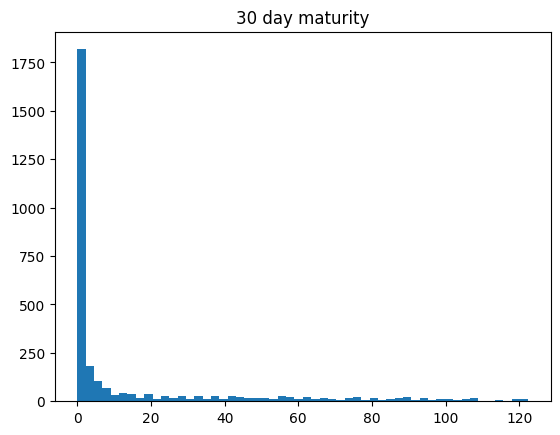

<Figure size 640x480 with 0 Axes>

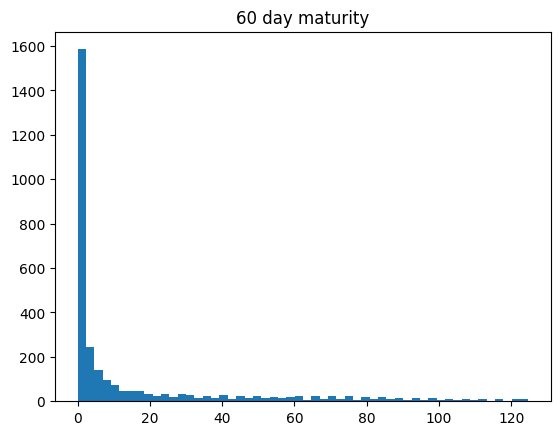

<Figure size 640x480 with 0 Axes>

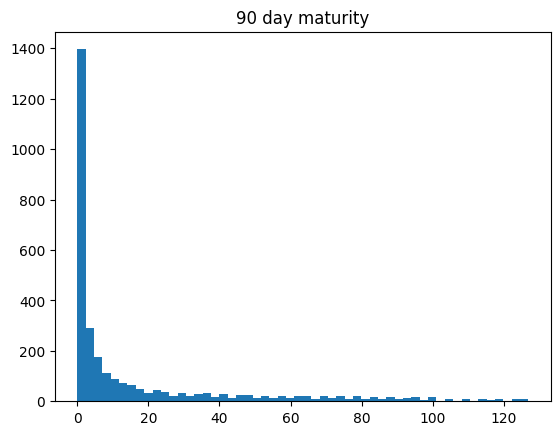

<Figure size 640x480 with 0 Axes>

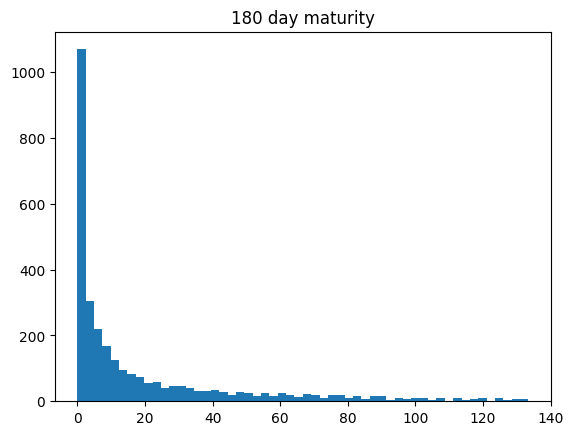

<Figure size 640x480 with 0 Axes>

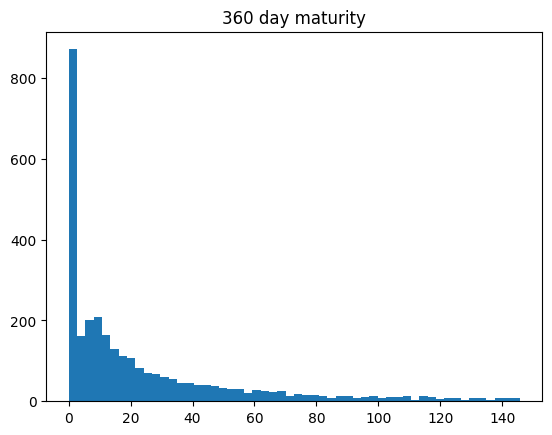

<Figure size 640x480 with 0 Axes>

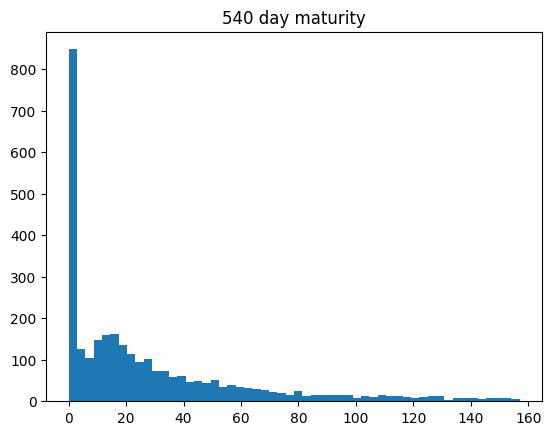

<Figure size 640x480 with 0 Axes>

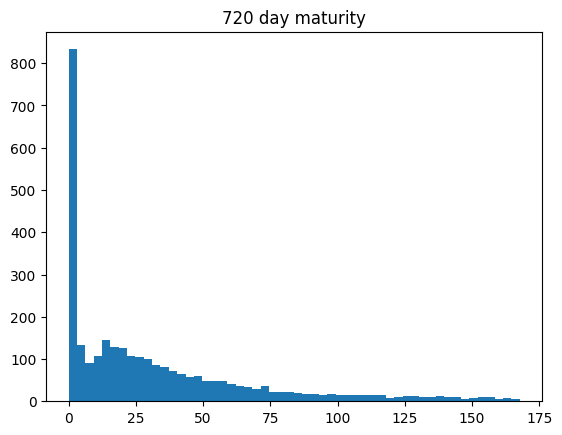

<Figure size 640x480 with 0 Axes>

In [13]:
for t in T:
    plt.figure()
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.title(f'{t} day maturity')
    plt.show()
    plt.clf()

# model training

In [14]:
import convsklearn
help(convsklearn)

Help on package convsklearn:

NAME
    convsklearn - a proprietary package of convenience wrappers for sklearn

PACKAGE CONTENTS
    convsklearn

DATA
    asian_trainer = <convsklearn.convsklearn.convsklearn object>
    barrier_trainer = <convsklearn.convsklearn.convsklearn object>
    categorical_features = ['averaging_type', 'w']
    numerical_features = ['spot_price', 'strike_price', 'days_to_maturity'...
    target_name = 'observed_price'

FILE
    e:\python\lib\site-packages\convsklearn\__init__.py




In [15]:
from convsklearn import barrier_trainer
barrier_trainer.solver = 'lbfgs'
barrier_trainer.activation_function = 'tanh'
features['observed_price'] = np.maximum(features['barrier_price'] + np.random.normal(scale=(0.15)**2,size=features.shape[0]),0)
    # apply slight peturbation
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()

train data count: 18000
test data count: 3000


In [16]:
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: tanh
solver: lbfgs
alpha: 0.0001


E:\Python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [17]:
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target',
        'outofsample_prediction':'dnn',
        'outofsample_error':'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
print(f"\n{dnn_barriers}")


in sample:
     RMSE: 0.4964007756679163
     MAE: 0.309722275906965

out of sample:
     RMSE: 2.413519229433249
     MAE: 1.491577059270808

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                   


         spot       k       b   price  vanilla       t  target     dnn   error
count 3000.00 3000.00 3000.00 3000.00  3000.00 3000.00 3000.00 3000.00 3000.00
mean   582.35  577.08  430.07   32.41    64.83  720.00   32.41   32.41    0.00
std      0.00   68.05   87.44   37.32    41.42    0.00   37.32   37.20    2.41
min    582.35  462.00  288.00    0.00    12.37  720.00    0.00    0.00   -8.11
25%    582.35  518.00  349.00    1.87    32.08  720.00    1.86    1.83   -1.22
50%    582.35  577.00  430.00   20.14    54.52  720.00   20.13   19.97   -0.14
75%    582.35  636.00  511.00   47.17    85.62  720.00   47.17   47.49    0.38
max    582.35  693.00  572.00  167.71   167.77  720.00  167.69  165.25    9.69

SPY down barrier options for Wednesday, October 23rd, 2024


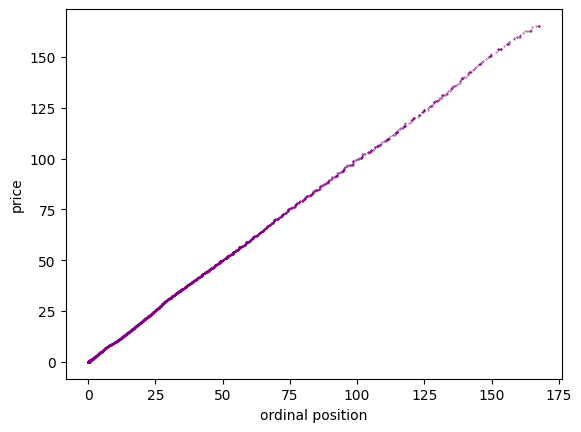

,spot,k,b,price,vanilla,type,w,t,target,dnn,error
0,582.35,693,572,0.25,85.44,DownOut,put,720,0.23,0.97,0.74
1,582.35,693,551,1.18,85.44,DownOut,put,720,1.17,1.67,0.50
2,582.35,693,531,2.83,85.44,DownOut,put,720,2.77,2.83,0.06
3,582.35,693,511,5.40,85.44,DownOut,put,720,5.42,4.78,-0.64
4,582.35,693,491,8.93,85.44,DownOut,put,720,8.96,7.83,-1.13
5,582.35,693,471,13.35,85.44,DownOut,put,720,13.32,12.00,-1.32
6,582.35,693,450,18.78,85.44,DownOut,put,720,18.73,17.39,-1.35
7,582.35,693,430,24.48,85.44,DownOut,put,720,24.49,23.15,-1.34
8,582.35,693,410,30.50,85.44,DownOut,put,720,30.49,29.22,-1.27
9,582.35,693,390,36.62,85.44,DownOut,put,720,36.65,35.37,-1.28


In [18]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")

target = pd.Series(np.sort(outsample_preview['target']))
estimate = pd.Series(np.sort(outsample_preview.iloc[:,-2]))
np.array(target.index)
plt.figure()
plt.scatter(target,estimate,color='purple',s=0.1)
plt.ylabel('price')
plt.xlabel('ordinal position')
plt.show()
outsample_preview

In [19]:
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 